# Book Recommendation System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

%matplotlib inline

C:\Users\Jay\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('D:/Personal/Practice Projects/Recommendation System/goodbooks/goodbooks-10k/ratings.csv')

In [3]:
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
dataset.shape

(981756, 3)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [6]:
train.head()

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [7]:
test.head()

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [8]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [9]:
n_books = len(dataset.book_id.unique())
n_books

10000

In [10]:
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [12]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [13]:
model.evaluate([test.user_id, test.book_id], test.rating)

196352/196352 [==============================] - 2s 11us/step


1.1337533162753772

In [14]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.697358] 5
[3.7322755] 4
[3.161058] 3
[4.2724395] 5
[3.0228083] 3
[4.424722] 3
[3.9317112] 3
[4.8768115] 4
[3.9131103] 3
[4.5833607] 5


[None, None, None, None, None, None, None, None, None, None]

## Visualizing Embeddings

In [15]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [16]:
book_em_weights[:5]

array([[-0.04159955, -0.01796059,  0.02388425,  0.04473335, -0.00462532],
       [-1.3159535 ,  1.4895648 , -1.1543206 ,  1.4727516 ,  1.5827322 ],
       [-1.3764862 ,  1.4382463 , -0.6511599 ,  1.3203669 ,  1.4942939 ],
       [-0.8390841 ,  1.1319371 , -1.4622757 ,  1.0212495 ,  1.2480013 ],
       [-1.3968911 ,  1.5591388 , -0.29752284,  1.6187718 ,  1.6268913 ]],
      dtype=float32)

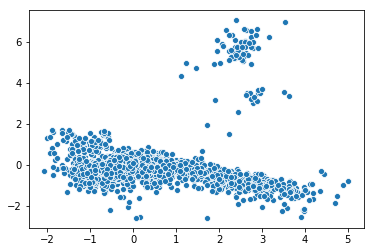

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [18]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

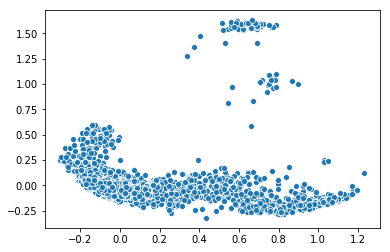

In [19]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.000s...
[t-SNE] Computed neighbors for 10001 samples in 0.850s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.017052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.025284
[t-SNE] KL

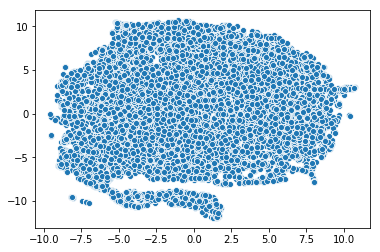

In [21]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making Recommendations

In [22]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [23]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [24]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([5858, 9517, 8998, 7660, 8258], dtype=int64)

In [25]:
# print predicted scores
predictions[recommended_book_ids]

array([4.311879 , 4.244976 , 4.1983595, 4.1297374, 4.128523 ],
      dtype=float32)

In [26]:
books = pd.read_csv('D:/Personal/Practice Projects/Recommendation System/goodbooks/goodbooks-10k/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [27]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
5857,5858,16297,16297,894955,171,425205959,9.780425e+12,Agatha Christie,1936.0,Cards on the Table,...,19577,23004,1031,112,857,6468,9372,6195,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7659,7660,21330,21330,2910,15,1401204864,9.781401e+12,"Bill Willingham, Mark Buckingham, Steve Leialo...",2005.0,"Fables, Volume 5: The Mean Seasons",...,17909,18221,545,120,340,2889,7435,7437,https://images.gr-assets.com/books/1327870458m...,https://images.gr-assets.com/books/1327870458s...
8257,8258,18594594,18594594,26341000,41,345547497,9.780346e+12,Karin Slaughter,2014.0,Cop Town,...,10660,13997,1704,274,780,3299,5612,4032,https://images.gr-assets.com/books/1384822680m...,https://images.gr-assets.com/books/1384822680s...
8997,8998,292740,292740,2457130,37,2266071289,9.782266e+12,Lorenzo Carcaterra,1995.0,Sleepers,...,9560,10772,553,73,304,1775,4088,4532,https://images.gr-assets.com/books/1327871596m...,https://images.gr-assets.com/books/1327871596s...
9516,9517,17810,17810,856346,39,NaN,9.780143e+12,"Ryū Murakami, Ralph McCarthy",1997.0,イン ザ・ミソスープ,...,9285,11545,950,313,1107,3586,4346,2193,https://images.gr-assets.com/books/1309282509m...,https://images.gr-assets.com/books/1309282509s...
